#Projeto 2 - Redes Neurais
###Professor: Germano Vasconselos


---


Alunos:
<br>
Felipe Jun Ting Lin - fjtl2@cin.ufpe.br
<br>
João Gabriel Vasconcelos - jgav@cin.ufpe.br
<br>
Maria Eduarda Mota - mebm@cin.ufpe.br
<br>
Rafael Bernardo Nunes Neto - rbnn@cin.ufpe.br

## Previsão do comportamento de preço do Bitcoin 

Neste projeto faremos a implementação de um LSTM para previsão do preço do Bitcoin de dezembro de 2014 a maio de 2018. Para isso, utilizaremos Tensorflow e Keras, além da biblioteca Numpy para operações matemáticas e Scikit-Learn para funções de métricas de avaliação.



#### Importação das Bibliotecas

In [ ]:
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import io
import math
%matplotlib inline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

A fim de trabalharmos com valores determinísticos, instanciamos uma seed manual.

In [ ]:
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
url = 'https://raw.githubusercontent.com/brianmwangy/predicting-bitcoin-prices-using-LSTM/master/btc.csv' 
df = pd.read_csv(url)
df = df.iloc[::-1].reset_index(drop=True)

### Análise 1 (Configuração Base)

##### Anállise de Dados

A partir do banco de preços fornecido no arquivo .csv , vamos fazer a análise dos dados informativos:

In [ ]:
df.head(5)

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
2,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
3,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
4,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [ ]:
df.describe()

,Open,High,Low,Close,Volume From,Volume To
count,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1.273000e+03
mean,2498.589018,2594.908704,2382.982019,2504.256002,10256.954990,4.454886e+07
std,3786.446583,3959.166670,3560.430575,3788.559184,9940.038576,1.055807e+08
min,120.000000,184.000000,0.060000,120.000000,0.000000,0.000000e+00
25%,340.000000,340.000000,340.000000,340.000000,4932.600000,2.042181e+06
50%,630.870000,639.990000,620.590000,634.970000,7405.230000,3.532958e+06
75%,2657.450000,2776.950000,2551.060000,2664.990000,12878.030000,3.532348e+07
max,19650.000000,19891.990000,19010.000000,19650.000000,160540.990000,1.237771e+09


Acima, temos estatísticas descritivas dos dados trabalhados.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1273 non-null   object 
 1   Symbol       1273 non-null   object 
 2   Open         1273 non-null   float64
 3   High         1273 non-null   float64
 4   Low          1273 non-null   float64
 5   Close        1273 non-null   float64
 6   Volume From  1273 non-null   float64
 7   Volume To    1273 non-null   float64
dtypes: float64(6), object(2)
memory usage: 79.7+ KB


##### Normalização e Plot

Como os dados possuem valor absoluto alto, faremos uma normalização dos dados, a fim de evitar que alguns parâmetros se sobressaiam a outros no processo de treinamento.



In [ ]:
df_to_use = df['Close'].values
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df_to_use.reshape(-1,1))

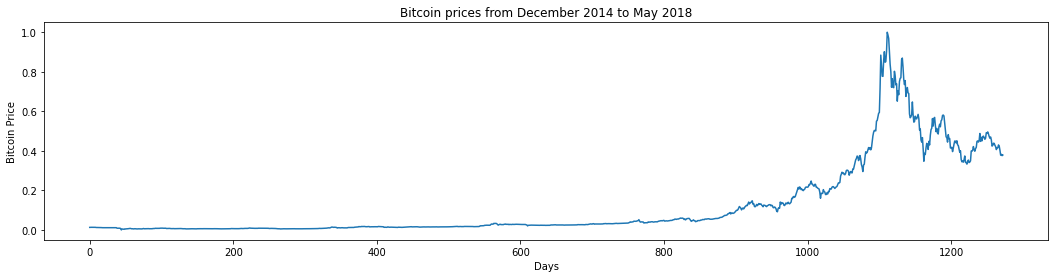

In [ ]:
figure = plt.figure(figsize=(18,4))
sns.lineplot(data=scaled_df, legend=None)
plt.xlabel('Days')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.show()

##### Funções Auxiliares

Trabalharemos com uma função para fazer a separação de treino e teste.

Usaremos a função `create_x_y`, que possui a finalidade de instanciar janelas de treinamento em sequências de dados.

In [ ]:
def create_x_y(data, time_steps=1):
    x, y = [], []
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps), 0] # pega todos os dias antes do dia que queremos prever
        x.append(v)
        y.append(data[i + time_steps, 0]) # pega o dia que queremos prever
    return np.array(x), np.array(y)

A fim de separar o dataset base, a função split_data é chamada.

In [ ]:
# 818 instâncias para treino e 205 para teste, com um test_size de 20%
def split_data(data, test_size, time_steps):
    X, y = create_x_y(data, time_steps)    

    length = X.shape[0]
    split = int(length * (1 - test_size))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    return X_train, y_train, X_test, y_test

time_steps = 250 # primeiramente, vamos treinar olhando para os 250 dias anteriores
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(818, 250)
(818,)
(205, 250)
(205,)


Aqui, instanciaremos a função que implementará o algoritmo de Early Stopping em cada um dos modelos manipulados.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

##### Treino e Teste

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(818, 250, 1)
(818, 1)
(205, 250, 1)
(205, 1)


Abaixo, temos o plot do nosso dataset segmentado

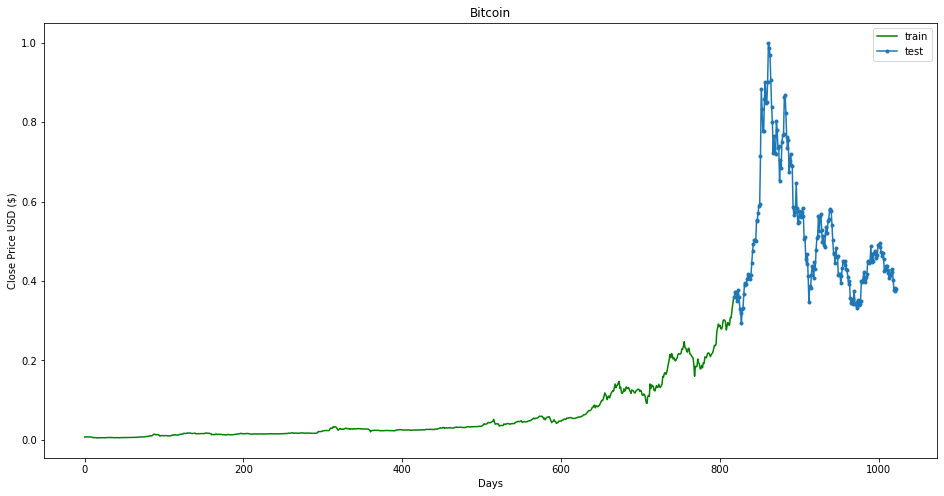

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label='train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label='test')
plt.title('Bitcoin')
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

##### Arquitetura da Rede e Configuração dos Parâmetros

Nessa etapa, configuramos os parâmetros a serem utilizados e manipulados no treino.

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.001
DROPOUT = 0.1
VERBOSE = 1
OPT = tf.keras.optimizers.Adam

Instanciando o modelo de LSTM:

In [ ]:
model_LSTM = tf.keras.Sequential()
model_LSTM.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT))
model_LSTM.add(Dense(1, activation='linear'))
model_LSTM.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE), 
    loss="mse")

In [ ]:
model_LSTM.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 250)               252000    
                                                                 
 dense_33 (Dense)            (None, 1)                 251       
                                                                 
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________


Agora, faremos o treinamento do modelo sem a manipulação de parâmetros.

In [ ]:
history_LSTM = model_LSTM.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    validation_split=0.2,
    callbacks=[callback])

Epoch 1/30
41/41 [==============================] - 6s 35ms/step - loss: 1.7033e-04 - val_loss: 3.9778e-04
Epoch 2/30
41/41 [==============================] - 1s 22ms/step - loss: 2.3947e-05 - val_loss: 2.8530e-04
Epoch 3/30
41/41 [==============================] - 1s 21ms/step - loss: 2.1933e-05 - val_loss: 4.8413e-04
Epoch 4/30
41/41 [==============================] - 1s 21ms/step - loss: 2.0495e-05 - val_loss: 3.6000e-04
Epoch 5/30
41/41 [==============================] - 1s 21ms/step - loss: 1.7605e-05 - val_loss: 3.2969e-04
Epoch 6/30
41/41 [==============================] - 1s 21ms/step - loss: 1.4153e-05 - val_loss: 4.2462e-04
Epoch 7/30
41/41 [==============================] - 1s 20ms/step - loss: 1.6891e-05 - val_loss: 2.9256e-04
Epoch 8/30
41/41 [==============================] - 1s 34ms/step - loss: 2.1075e-05 - val_loss: 3.1680e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 1.8566e-05 - val_loss: 3.0901e-04
Epoch 10/30
41/41 [==================

A fim de facilitar o processo de avaliação dos modelos referentes no documento, usaremos a função model_evaluation abaixo:

In [ ]:
def model_evaluation(history, model, scaler, X_test, X_train, y_train, y_test):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper left')
  plt.show()

  y_hat = model.predict(X_test)
  y_t = model.predict(X_train)

  y_test_inverse = scaler.inverse_transform(y_test)
  y_hat_inverse = scaler.inverse_transform(y_hat)
 
  plt.plot(y_test_inverse, label='Actual Price', color = 'green')
  plt.plot(y_hat_inverse, label='Predicted Price', color = 'red')

  plt.title('Bitcoin price prediction')
  plt.xlabel('Time [days]')
  plt.ylabel('Price')
  plt.legend(['Actual Price', 'Predicted Price'], loc = 'upper right')
  ## adicionar legenda com os parametros atuais

  trainScore = math.sqrt(mean_squared_error(y_train[0], y_t[0]))
  print('Train Score: %.4f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test[0], y_hat[0]))
  print('Test Score: %.4f RMSE' % (testScore))
  
  plt.show()

Com o plot dos dados, conseguimos ter uma avaliação mais palpável do treinamento. Assim, faremos esse processo a seguir:

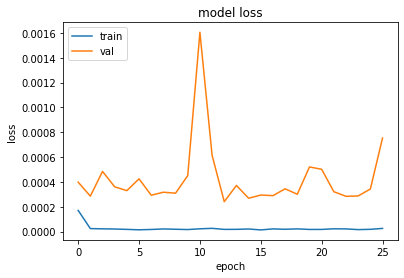

26/26 [==============================] - 0s 10ms/step
Train Score: 0.0010 RMSE
Test Score: 0.0144 RMSE


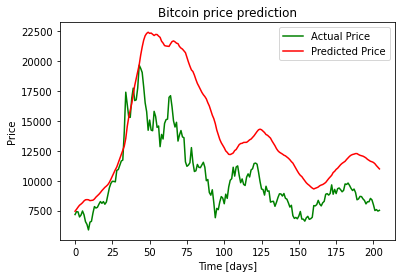

In [ ]:
model_evaluation(history_LSTM, model_LSTM, scaler, X_test, X_train, y_train, y_test)

##### Análise de Resultados

A partir dos dados obtidos, observamos um comportamento similar (no quesito de aumento ou diminuição do valor do Bitcoin ao longo do tempo) do conjunto de treino e teste. 
Apesar de as magnitudes se encontrarem na ordem de grandeza, suas valorações ainda divergem. 
Por fim, obtivemos um test score de 0.0244 RMSE.

### Análise 2 (Número de Camadas LSTM)

Nessa etapa, faremos testes com diferentes números de camadas LSTM, a fim de analisar e encontrar a melhor estrutura a ser aplicada no projeto

#### 2 camadas de LSTM

Usando 2 camadas de LSTM:

In [ ]:
model_LSTM_2 = tf.keras.Sequential()
model_LSTM_2.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2.add(Dense(1, activation='linear'))
model_LSTM_2.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE),
    loss="mse"
)


In [ ]:
model_LSTM_2.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 250, 250)          252000    
                                                                 
 lstm_76 (LSTM)              (None, 250)               501000    
                                                                 
 dense_34 (Dense)            (None, 1)                 251       
                                                                 
Total params: 753,251
Trainable params: 753,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM_2 = model_LSTM_2.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)


Epoch 1/30
41/41 [==============================] - 6s 48ms/step - loss: 1.4881e-04 - val_loss: 3.4576e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 1.9332e-05 - val_loss: 4.2218e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0926e-05 - val_loss: 0.0014
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 1.9416e-05 - val_loss: 4.2291e-04
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 1.9198e-05 - val_loss: 4.4707e-04
Epoch 6/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7398e-05 - val_loss: 4.6208e-04
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 2.2809e-05 - val_loss: 3.6850e-04
Epoch 8/30
41/41 [==============================] - 1s 28ms/step - loss: 2.1086e-05 - val_loss: 2.9873e-04
Epoch 9/30
41/41 [==============================] - 1s 32ms/step - loss: 2.3554e-05 - val_loss: 6.9500e-04
Epoch 10/30
41/41 [======================

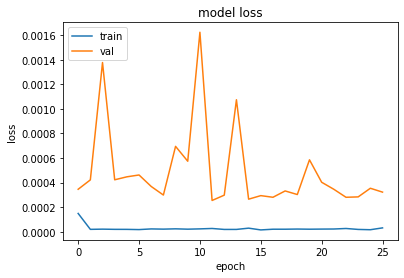

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0023 RMSE
Test Score: 0.0368 RMSE


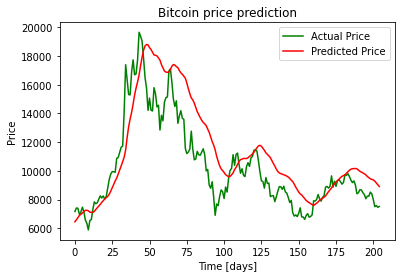

In [ ]:
model_evaluation(history_LSTM_2, model_LSTM_2, scaler, X_test, X_train, y_train, y_test)

##### Análise de Resultados

A partir dos resultados obtidos, nota-se uma perfomance superior ao teste com uma camada.

#### 3 camadas de LSTM

Usando 3 camadas de LSTM, temos:

In [ ]:
model_LSTM_3 = tf.keras.Sequential()
model_LSTM_3.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_3.add(LSTM(time_steps, dropout=DROPOUT, return_sequences=True))
model_LSTM_3.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_3.add(Dense(1, activation='linear'))
model_LSTM_3.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_3 = model_LSTM_3.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 8s 68ms/step - loss: 1.2745e-04 - val_loss: 4.8255e-04
Epoch 2/30
41/41 [==============================] - 2s 43ms/step - loss: 3.3104e-05 - val_loss: 4.7518e-04
Epoch 3/30
41/41 [==============================] - 2s 39ms/step - loss: 2.2133e-05 - val_loss: 5.8620e-04
Epoch 4/30
41/41 [==============================] - 2s 39ms/step - loss: 2.5639e-05 - val_loss: 0.0012
Epoch 5/30
41/41 [==============================] - 2s 40ms/step - loss: 2.3655e-05 - val_loss: 5.1182e-04
Epoch 6/30
41/41 [==============================] - 2s 41ms/step - loss: 1.7995e-05 - val_loss: 4.1045e-04
Epoch 7/30
41/41 [==============================] - 2s 40ms/step - loss: 2.5105e-05 - val_loss: 5.3114e-04
Epoch 8/30
41/41 [==============================] - 2s 40ms/step - loss: 2.5148e-05 - val_loss: 4.9065e-04
Epoch 9/30
41/41 [==============================] - 2s 40ms/step - loss: 2.5595e-05 - val_loss: 9.1324e-04
Epoch 10/30
41/41 [======================

In [ ]:
model_LSTM_3.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 250, 250)          252000    
                                                                 
 lstm_78 (LSTM)              (None, 250, 250)          501000    
                                                                 
 lstm_79 (LSTM)              (None, 250)               501000    
                                                                 
 dense_35 (Dense)            (None, 1)                 251       
                                                                 
Total params: 1,254,251
Trainable params: 1,254,251
Non-trainable params: 0
_________________________________________________________________


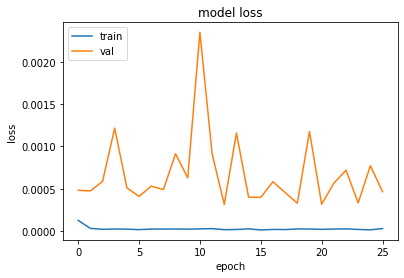

26/26 [==============================] - 0s 18ms/step
Train Score: 0.0029 RMSE
Test Score: 0.0443 RMSE


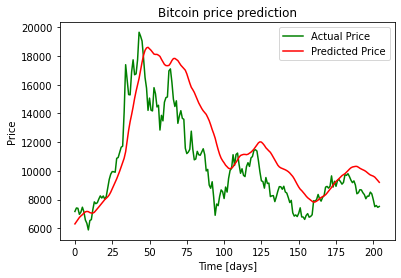

In [ ]:
model_evaluation(history_LSTM_3, model_LSTM_3, scaler, X_test, X_train, y_train, y_test)

##### Análise de Resultados

A partir dos resultados obtidos, nota-se uma performance inferior ao teste com duas camadas. Sendo assim, até o momento, duas camadas aparenta ser a estrutura mais coerente.

#### 4 camadas de LSTM

Usando 4 camadas de LSTM:

In [ ]:
model_LSTM_4 = tf.keras.Sequential()
model_LSTM_4.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_4.add(LSTM(time_steps, dropout=DROPOUT, return_sequences=True))
model_LSTM_4.add(LSTM(time_steps, dropout=DROPOUT, return_sequences=True))
model_LSTM_4.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_4.add(Dense(1, activation='linear'))
model_LSTM_4.compile(
    optimizer=OPT(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_4 = model_LSTM_4.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 12s 86ms/step - loss: 1.6856e-04 - val_loss: 8.2629e-04
Epoch 2/30
41/41 [==============================] - 2s 52ms/step - loss: 2.9660e-05 - val_loss: 8.0060e-04
Epoch 3/30
41/41 [==============================] - 2s 52ms/step - loss: 2.8684e-05 - val_loss: 0.0012
Epoch 4/30
41/41 [==============================] - 2s 52ms/step - loss: 4.2996e-05 - val_loss: 0.0048
Epoch 5/30
41/41 [==============================] - 2s 52ms/step - loss: 3.6049e-05 - val_loss: 7.9948e-04
Epoch 6/30
41/41 [==============================] - 2s 52ms/step - loss: 2.1492e-05 - val_loss: 5.1834e-04
Epoch 7/30
41/41 [==============================] - 2s 53ms/step - loss: 2.8540e-05 - val_loss: 0.0010
Epoch 8/30
41/41 [==============================] - 2s 53ms/step - loss: 2.9215e-05 - val_loss: 5.5652e-04
Epoch 9/30
41/41 [==============================] - 2s 53ms/step - loss: 2.3326e-05 - val_loss: 6.8680e-04
Epoch 10/30
41/41 [=============================

In [ ]:
model_LSTM_4.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 250, 250)          252000    
                                                                 
 lstm_81 (LSTM)              (None, 250, 250)          501000    
                                                                 
 lstm_82 (LSTM)              (None, 250, 250)          501000    
                                                                 
 lstm_83 (LSTM)              (None, 250)               501000    
                                                                 
 dense_36 (Dense)            (None, 1)                 251       
                                                                 
Total params: 1,755,251
Trainable params: 1,755,251
Non-trainable params: 0
_________________________________________________________________


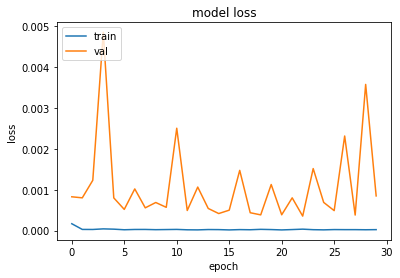

26/26 [==============================] - 1s 22ms/step
Train Score: 0.0032 RMSE
Test Score: 0.0241 RMSE


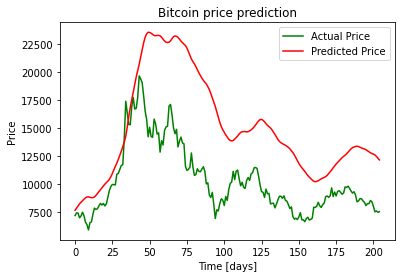

In [ ]:
model_evaluation(history_LSTM_4, model_LSTM_4, scaler, X_test, X_train, y_train, y_test)

##### Análise de Resultados

A partir dos resultados obtidos, nota-se uma performance inferior ao teste com duas camadas.

#### Continuidade

Em virtude dos resultados encontrados, utilizaremos a partir de agora a rede com 2 camadas LSTM.

### Análise 3 (Algoritmo de Otimização)

Agora, vamos analisar a influência dos diferentes algoritmos de otimização aplicados na rede com 2 LSTMs.

#### ADAM Optmizer

Aplicando o ADAM Optimizer:

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 47ms/step - loss: 1.5160e-04 - val_loss: 4.2931e-04
Epoch 2/30
41/41 [==============================] - 1s 26ms/step - loss: 1.9866e-05 - val_loss: 4.2122e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0802e-05 - val_loss: 0.0015
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0191e-05 - val_loss: 4.2688e-04
Epoch 5/30
41/41 [==============================] - 1s 27ms/step - loss: 1.9951e-05 - val_loss: 4.0646e-04
Epoch 6/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7097e-05 - val_loss: 6.3256e-04
Epoch 7/30
41/41 [==============================] - 1s 27ms/step - loss: 2.2474e-05 - val_loss: 3.7542e-04
Epoch 8/30
41/41 [==============================] - 1s 28ms/step - loss: 2.1556e-05 - val_loss: 2.9706e-04
Epoch 9/30
41/41 [==============================] - 1s 27ms/step - loss: 2.5216e-05 - val_loss: 5.7168e-04
Epoch 10/30
41/41 [======================

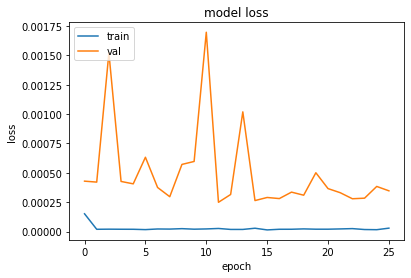

26/26 [==============================] - 0s 13ms/step
Train Score: 0.0020 RMSE
Test Score: 0.0379 RMSE


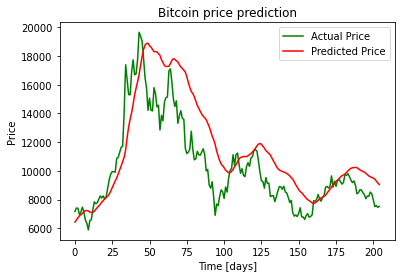

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Stochastic Gradient Descent

In [ ]:
model_LSTM_2_sgd = tf.keras.Sequential()
model_LSTM_2_sgd.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_sgd.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_sgd.add(Dense(1, activation='linear'))
model_LSTM_2_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_sgd = model_LSTM_2_sgd.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 51ms/step - loss: 7.9524e-04 - val_loss: 0.0314
Epoch 2/30
41/41 [==============================] - 1s 26ms/step - loss: 5.6293e-04 - val_loss: 0.0297
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 4.3823e-04 - val_loss: 0.0285
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 3.7158e-04 - val_loss: 0.0277
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 3.3553e-04 - val_loss: 0.0270
Epoch 6/30
41/41 [==============================] - 1s 26ms/step - loss: 3.1682e-04 - val_loss: 0.0266
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 3.0637e-04 - val_loss: 0.0263
Epoch 8/30
41/41 [==============================] - 1s 27ms/step - loss: 3.0190e-04 - val_loss: 0.0260
Epoch 9/30
41/41 [==============================] - 1s 27ms/step - loss: 2.9867e-04 - val_loss: 0.0258
Epoch 10/30
41/41 [==============================] - 1s 27ms/step - loss:

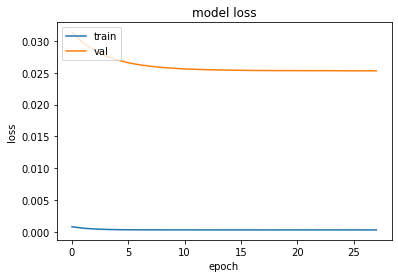

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0188 RMSE
Test Score: 0.3211 RMSE


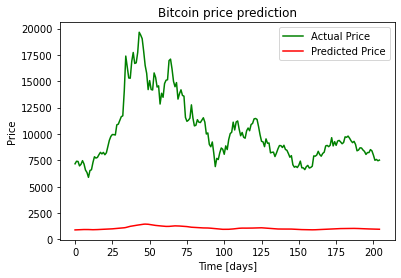

In [ ]:
model_evaluation(history_LSTM_2_sgd, model_LSTM_2_sgd, scaler, X_test, X_train, y_train, y_test)

#### RMSprop

In [ ]:
model_LSTM_2_rms = tf.keras.Sequential()
model_LSTM_2_rms.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_rms.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_rms.add(Dense(1, activation='linear'))
model_LSTM_2_rms.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_rms = model_LSTM_2_rms.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 5s 48ms/step - loss: 5.2908e-04 - val_loss: 0.0186
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 3.8596e-04 - val_loss: 0.0133
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 3.2288e-04 - val_loss: 0.0152
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 2.8215e-04 - val_loss: 0.0153
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 2.5111e-04 - val_loss: 0.0072
Epoch 6/30
41/41 [==============================] - 1s 28ms/step - loss: 2.5865e-04 - val_loss: 0.0073
Epoch 7/30
41/41 [==============================] - 1s 28ms/step - loss: 2.0172e-04 - val_loss: 0.0085
Epoch 8/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0459e-04 - val_loss: 0.0073
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0832e-04 - val_loss: 0.0075
Epoch 10/30
41/41 [==============================] - 1s 27ms/step - loss:

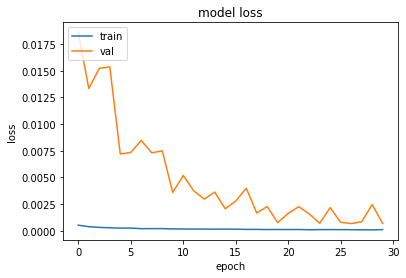

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0120 RMSE
Test Score: 0.0787 RMSE


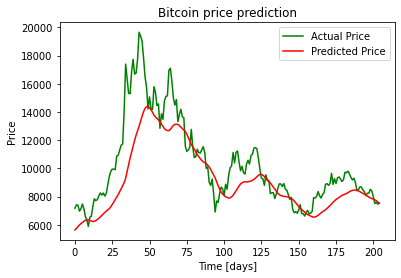

In [ ]:
model_evaluation(history_LSTM_2_rms, model_LSTM_2_rms, scaler, X_test, X_train, y_train, y_test)

#### Adadelta

In [ ]:
model_LSTM_2_ada = tf.keras.Sequential()
model_LSTM_2_ada.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_ada.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_ada.add(Dense(1, activation='linear'))
model_LSTM_2_ada.compile(
    optimizer=tf.keras.optimizers.Adadelta(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_ada = model_LSTM_2_ada.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 48ms/step - loss: 0.0010 - val_loss: 0.0368
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 9.3167e-04 - val_loss: 0.0361
Epoch 3/30
41/41 [==============================] - 1s 28ms/step - loss: 8.4838e-04 - val_loss: 0.0355
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 7.7498e-04 - val_loss: 0.0349
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 7.0716e-04 - val_loss: 0.0343
Epoch 6/30
41/41 [==============================] - 1s 26ms/step - loss: 6.4638e-04 - val_loss: 0.0337
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 5.9325e-04 - val_loss: 0.0332
Epoch 8/30
41/41 [==============================] - 1s 26ms/step - loss: 5.4582e-04 - val_loss: 0.0327
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 5.0538e-04 - val_loss: 0.0322
Epoch 10/30
41/41 [==============================] - 1s 26ms/step - loss: 4.7

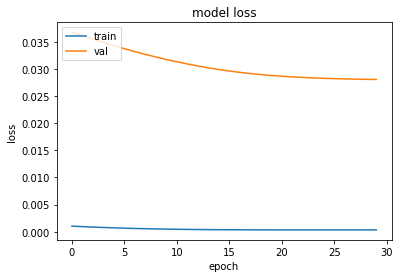

26/26 [==============================] - 0s 15ms/step
Train Score: 0.0194 RMSE
Test Score: 0.3360 RMSE


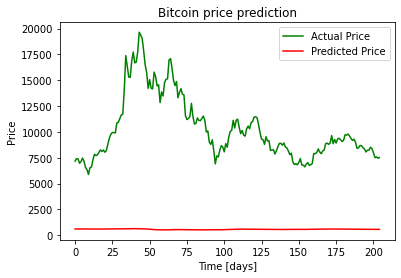

In [ ]:
model_evaluation(history_LSTM_2_ada, model_LSTM_2_ada, scaler, X_test, X_train, y_train, y_test)

#### Continuidade

Observando o RMSE dos algoritmos testados, notamos que obtemos uma menor raiz quadrada média do erro com o otimizador ADAM na rede com 2 camadas. Dessa forma, seguiremos utilizando esse modelo para as próximas análises.

### Análise 4 (Taxa de Aprendizagem)

#### Taxa de Aprendizado: 0.001

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 5s 47ms/step - loss: 1.3493e-04 - val_loss: 3.0589e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 1.9596e-05 - val_loss: 4.2482e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0957e-05 - val_loss: 0.0015
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 1.9518e-05 - val_loss: 4.4432e-04
Epoch 5/30
41/41 [==============================] - 1s 29ms/step - loss: 1.9673e-05 - val_loss: 3.8975e-04
Epoch 6/30
41/41 [==============================] - 1s 31ms/step - loss: 1.6987e-05 - val_loss: 4.2484e-04
Epoch 7/30
41/41 [==============================] - 1s 31ms/step - loss: 2.3838e-05 - val_loss: 4.2534e-04
Epoch 8/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0860e-05 - val_loss: 2.9327e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.4452e-05 - val_loss: 6.8013e-04
Epoch 10/30
41/41 [======================

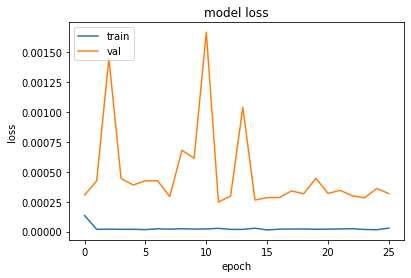

26/26 [==============================] - 0s 13ms/step
Train Score: 0.0020 RMSE
Test Score: 0.0288 RMSE


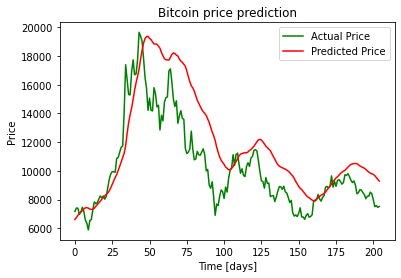

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Taxa de Aprendizado: 0.00075

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE*0.75),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 7s 49ms/step - loss: 1.4978e-04 - val_loss: 3.5713e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0652e-05 - val_loss: 3.8746e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 2.1944e-05 - val_loss: 5.4779e-04
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7431e-05 - val_loss: 3.6059e-04
Epoch 5/30
41/41 [==============================] - 1s 27ms/step - loss: 1.8171e-05 - val_loss: 3.6084e-04
Epoch 6/30
41/41 [==============================] - 1s 29ms/step - loss: 1.5317e-05 - val_loss: 3.4729e-04
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 2.1963e-05 - val_loss: 3.2476e-04
Epoch 8/30
41/41 [==============================] - 1s 27ms/step - loss: 1.8500e-05 - val_loss: 3.3271e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.1379e-05 - val_loss: 5.7123e-04
Epoch 10/30
41/41 [==================

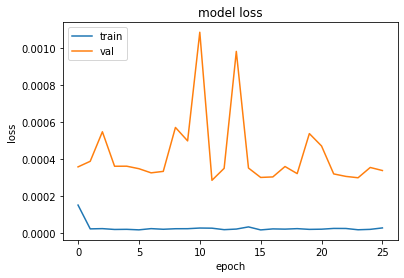

26/26 [==============================] - 0s 17ms/step
Train Score: 0.0000 RMSE
Test Score: 0.0250 RMSE


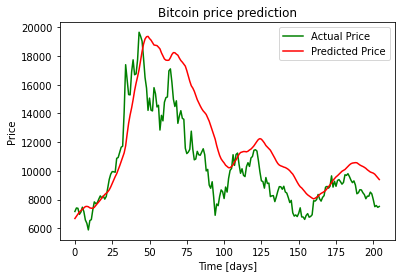

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Taxa de Aprendizado: 0.0005

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE*0.5),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 51ms/step - loss: 1.6721e-04 - val_loss: 3.9274e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 2.4307e-05 - val_loss: 4.0824e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.2235e-05 - val_loss: 6.5347e-04
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0053e-05 - val_loss: 4.0204e-04
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7322e-05 - val_loss: 3.7695e-04
Epoch 6/30
41/41 [==============================] - 1s 28ms/step - loss: 1.5281e-05 - val_loss: 4.7567e-04
Epoch 7/30
41/41 [==============================] - 1s 29ms/step - loss: 1.6688e-05 - val_loss: 3.8450e-04
Epoch 8/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0201e-05 - val_loss: 3.9446e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 1.8599e-05 - val_loss: 3.6522e-04
Epoch 10/30
41/41 [==================

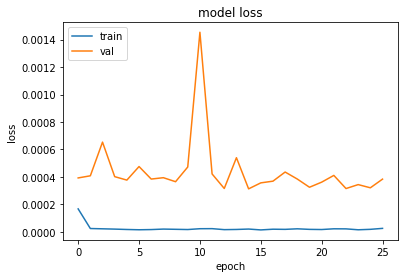

26/26 [==============================] - 0s 12ms/step
Train Score: 0.0006 RMSE
Test Score: 0.0213 RMSE


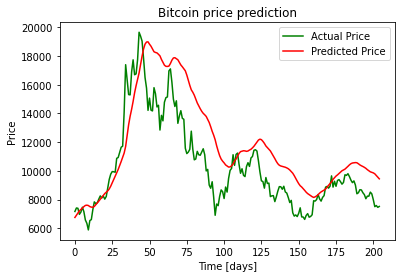

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Taxa de Aprendizado: 0.00025

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE*0.25),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 47ms/step - loss: 1.5395e-04 - val_loss: 7.5242e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 1.8855e-05 - val_loss: 4.2541e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0716e-05 - val_loss: 5.1731e-04
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7048e-05 - val_loss: 4.7111e-04
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 1.6085e-05 - val_loss: 4.4811e-04
Epoch 6/30
41/41 [==============================] - 1s 28ms/step - loss: 1.5443e-05 - val_loss: 4.1440e-04
Epoch 7/30
41/41 [==============================] - 1s 28ms/step - loss: 1.6230e-05 - val_loss: 3.8434e-04
Epoch 8/30
41/41 [==============================] - 1s 27ms/step - loss: 1.7702e-05 - val_loss: 5.8582e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 1.7736e-05 - val_loss: 4.4171e-04
Epoch 10/30
41/41 [==================

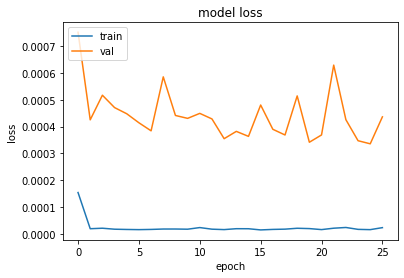

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0009 RMSE
Test Score: 0.0554 RMSE


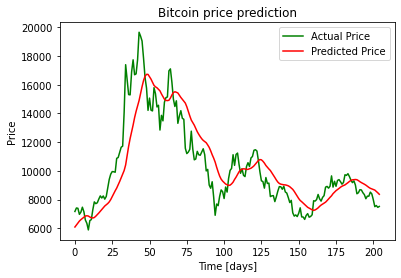

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Taxa de Aprendizado: 0.0001

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE*0.1),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 47ms/step - loss: 2.3826e-04 - val_loss: 0.0036
Epoch 2/30
41/41 [==============================] - 1s 26ms/step - loss: 2.5195e-05 - val_loss: 4.9329e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 1.6881e-05 - val_loss: 4.8666e-04
Epoch 4/30
41/41 [==============================] - 1s 28ms/step - loss: 1.6512e-05 - val_loss: 5.4236e-04
Epoch 5/30
41/41 [==============================] - 1s 28ms/step - loss: 1.6774e-05 - val_loss: 5.0289e-04
Epoch 6/30
41/41 [==============================] - 1s 27ms/step - loss: 1.4783e-05 - val_loss: 4.8874e-04
Epoch 7/30
41/41 [==============================] - 1s 27ms/step - loss: 1.7868e-05 - val_loss: 4.9652e-04
Epoch 8/30
41/41 [==============================] - 1s 28ms/step - loss: 1.6989e-05 - val_loss: 5.4923e-04
Epoch 9/30
41/41 [==============================] - 1s 27ms/step - loss: 1.8804e-05 - val_loss: 4.3539e-04
Epoch 10/30
41/41 [======================

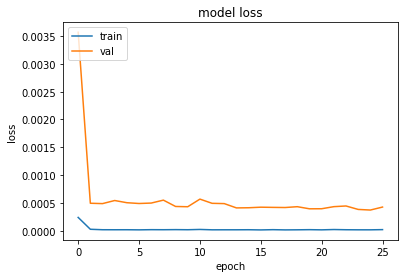

26/26 [==============================] - 0s 13ms/step
Train Score: 0.0016 RMSE
Test Score: 0.0528 RMSE


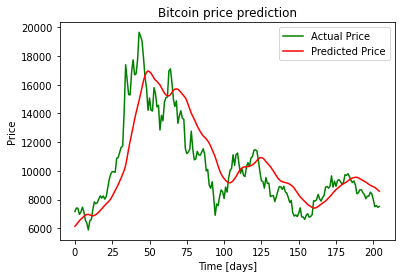

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Continuidade

Observando o RMSE de teste e treinamento, para evitar overfitting, utilizaremos o learning rate 0,001 nas próximas análises.

### Análise 5 (Dropout)

#### Dropout: 0.1

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 47ms/step - loss: 1.7401e-04 - val_loss: 5.4991e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0553e-05 - val_loss: 4.1826e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.1231e-05 - val_loss: 0.0013
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0233e-05 - val_loss: 4.1109e-04
Epoch 5/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0627e-05 - val_loss: 4.3191e-04
Epoch 6/30
41/41 [==============================] - 1s 27ms/step - loss: 1.7297e-05 - val_loss: 5.8285e-04
Epoch 7/30
41/41 [==============================] - 1s 28ms/step - loss: 2.2040e-05 - val_loss: 3.2571e-04
Epoch 8/30
41/41 [==============================] - 1s 29ms/step - loss: 2.1192e-05 - val_loss: 3.0797e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.4141e-05 - val_loss: 5.9160e-04
Epoch 10/30
41/41 [======================

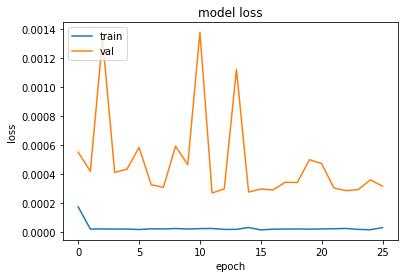

26/26 [==============================] - 0s 12ms/step
Train Score: 0.0017 RMSE
Test Score: 0.0307 RMSE


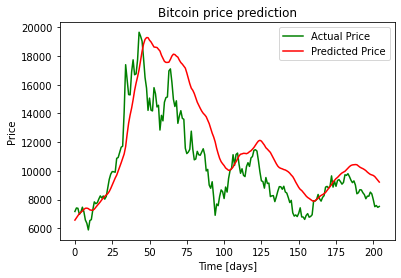

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Dropout: 0.2

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT*2, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 49ms/step - loss: 1.6796e-04 - val_loss: 7.8196e-04
Epoch 2/30
41/41 [==============================] - 1s 26ms/step - loss: 4.3660e-05 - val_loss: 5.6842e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 3.4101e-05 - val_loss: 0.0026
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 3.0254e-05 - val_loss: 6.3638e-04
Epoch 5/30
41/41 [==============================] - 1s 27ms/step - loss: 3.2855e-05 - val_loss: 5.5301e-04
Epoch 6/30
41/41 [==============================] - 1s 27ms/step - loss: 3.5605e-05 - val_loss: 5.6519e-04
Epoch 7/30
41/41 [==============================] - 1s 29ms/step - loss: 4.1372e-05 - val_loss: 5.4933e-04
Epoch 8/30
41/41 [==============================] - 1s 30ms/step - loss: 3.2609e-05 - val_loss: 5.5771e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.9513e-05 - val_loss: 4.8019e-04
Epoch 10/30
41/41 [======================

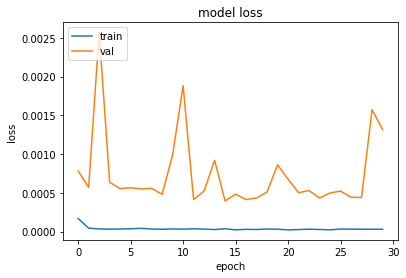

26/26 [==============================] - 0s 16ms/step
Train Score: 0.0006 RMSE
Test Score: 0.0356 RMSE


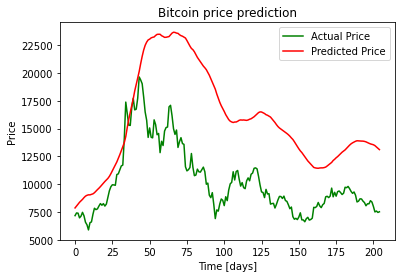

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Dropout: 0.3

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT*3, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 7s 52ms/step - loss: 1.3537e-04 - val_loss: 4.7734e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 4.3130e-05 - val_loss: 5.0296e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 4.1173e-05 - val_loss: 0.0016
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 3.9583e-05 - val_loss: 0.0028
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 4.9154e-05 - val_loss: 0.0014
Epoch 6/30
41/41 [==============================] - 1s 27ms/step - loss: 4.5440e-05 - val_loss: 5.8002e-04
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 5.5224e-05 - val_loss: 6.2242e-04
Epoch 8/30
41/41 [==============================] - 1s 28ms/step - loss: 5.1538e-05 - val_loss: 6.6707e-04
Epoch 9/30
41/41 [==============================] - 1s 28ms/step - loss: 3.8544e-05 - val_loss: 5.3938e-04
Epoch 10/30
41/41 [==============================

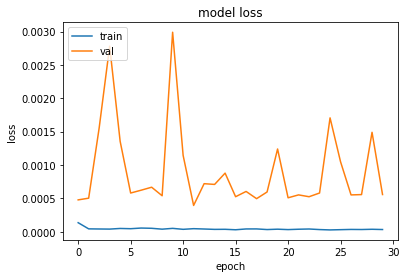

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0026 RMSE
Test Score: 0.0323 RMSE


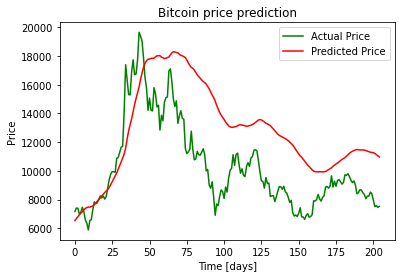

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Dropout: 0.4

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT*4, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 7s 51ms/step - loss: 1.4888e-04 - val_loss: 3.5905e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 5.4365e-05 - val_loss: 5.0390e-04
Epoch 3/30
41/41 [==============================] - 1s 29ms/step - loss: 5.9662e-05 - val_loss: 0.0014
Epoch 4/30
41/41 [==============================] - 1s 30ms/step - loss: 5.7642e-05 - val_loss: 0.0062
Epoch 5/30
41/41 [==============================] - 1s 28ms/step - loss: 6.8195e-05 - val_loss: 8.5023e-04
Epoch 6/30
41/41 [==============================] - 1s 31ms/step - loss: 5.0349e-05 - val_loss: 0.0013
Epoch 7/30
41/41 [==============================] - 1s 32ms/step - loss: 8.8054e-05 - val_loss: 8.0257e-04
Epoch 8/30
41/41 [==============================] - 1s 28ms/step - loss: 6.2470e-05 - val_loss: 6.4824e-04
Epoch 9/30
41/41 [==============================] - 1s 27ms/step - loss: 4.5646e-05 - val_loss: 6.9258e-04
Epoch 10/30
41/41 [==============================

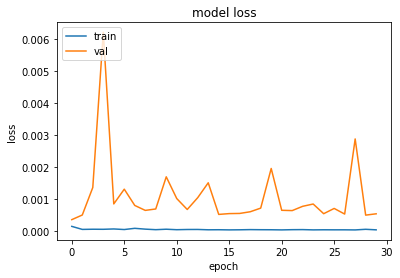

26/26 [==============================] - 0s 17ms/step
Train Score: 0.0039 RMSE
Test Score: 0.0393 RMSE


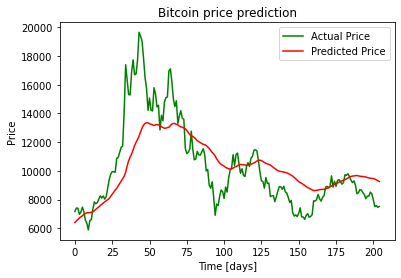

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Continuidade

Considerando essas análises, utilizaremos o valor de dropout de 10%, já que observamos um baixo RMSE tanto para o treinamento ($0,0017$) quanto para os testes ($0,0307$).

### Análise 6 (Batch Size)



#### Batch Size: 16

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 48ms/step - loss: 1.2653e-04 - val_loss: 3.4805e-04
Epoch 2/30
41/41 [==============================] - 1s 27ms/step - loss: 1.9951e-05 - val_loss: 4.0972e-04
Epoch 3/30
41/41 [==============================] - 1s 27ms/step - loss: 2.1283e-05 - val_loss: 0.0016
Epoch 4/30
41/41 [==============================] - 1s 27ms/step - loss: 2.0024e-05 - val_loss: 4.2090e-04
Epoch 5/30
41/41 [==============================] - 1s 28ms/step - loss: 1.9780e-05 - val_loss: 4.2650e-04
Epoch 6/30
41/41 [==============================] - 1s 28ms/step - loss: 1.6865e-05 - val_loss: 3.8597e-04
Epoch 7/30
41/41 [==============================] - 1s 27ms/step - loss: 2.3880e-05 - val_loss: 5.2547e-04
Epoch 8/30
41/41 [==============================] - 1s 26ms/step - loss: 2.1029e-05 - val_loss: 2.9087e-04
Epoch 9/30
41/41 [==============================] - 1s 26ms/step - loss: 2.4428e-05 - val_loss: 7.1788e-04
Epoch 10/30
41/41 [======================

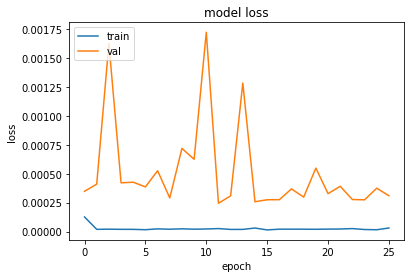

26/26 [==============================] - 0s 12ms/step
Train Score: 0.0024 RMSE
Test Score: 0.0346 RMSE


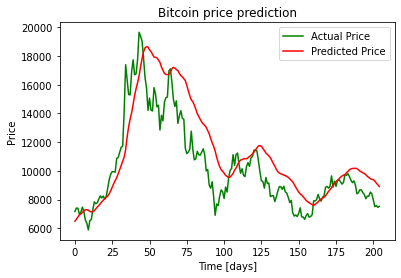

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Batch Size: 32

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE*2,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
21/21 [==============================] - 5s 75ms/step - loss: 2.2466e-04 - val_loss: 0.0012
Epoch 2/30
21/21 [==============================] - 1s 33ms/step - loss: 4.2957e-05 - val_loss: 6.6606e-04
Epoch 3/30
21/21 [==============================] - 1s 33ms/step - loss: 2.3603e-05 - val_loss: 3.2983e-04
Epoch 4/30
21/21 [==============================] - 1s 33ms/step - loss: 1.7639e-05 - val_loss: 4.2857e-04
Epoch 5/30
21/21 [==============================] - 1s 33ms/step - loss: 1.4691e-05 - val_loss: 3.9993e-04
Epoch 6/30
21/21 [==============================] - 1s 33ms/step - loss: 1.3524e-05 - val_loss: 3.8705e-04
Epoch 7/30
21/21 [==============================] - 1s 33ms/step - loss: 1.8555e-05 - val_loss: 3.3839e-04
Epoch 8/30
21/21 [==============================] - 1s 34ms/step - loss: 1.8680e-05 - val_loss: 6.4013e-04
Epoch 9/30
21/21 [==============================] - 1s 34ms/step - loss: 1.6564e-05 - val_loss: 3.5731e-04
Epoch 10/30
21/21 [======================

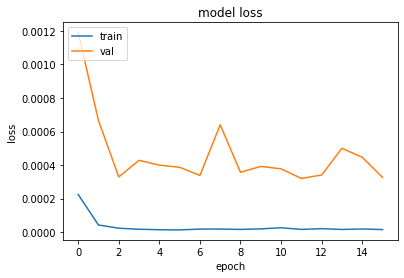

26/26 [==============================] - 0s 14ms/step
Train Score: 0.0010 RMSE
Test Score: 0.0434 RMSE


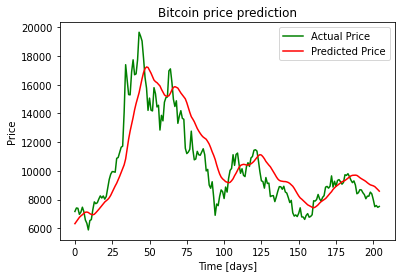

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Batch Size: 64

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE*4,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
11/11 [==============================] - 6s 136ms/step - loss: 3.1587e-04 - val_loss: 0.0033
Epoch 2/30
11/11 [==============================] - 0s 46ms/step - loss: 4.1620e-05 - val_loss: 5.0383e-04
Epoch 3/30
11/11 [==============================] - 0s 45ms/step - loss: 1.8361e-05 - val_loss: 4.8198e-04
Epoch 4/30
11/11 [==============================] - 1s 47ms/step - loss: 1.6085e-05 - val_loss: 3.5166e-04
Epoch 5/30
11/11 [==============================] - 1s 50ms/step - loss: 1.7078e-05 - val_loss: 3.8538e-04
Epoch 6/30
11/11 [==============================] - 1s 48ms/step - loss: 1.4036e-05 - val_loss: 3.6315e-04
Epoch 7/30
11/11 [==============================] - 1s 49ms/step - loss: 1.6056e-05 - val_loss: 3.4364e-04
Epoch 8/30
11/11 [==============================] - 1s 48ms/step - loss: 1.8942e-05 - val_loss: 3.3428e-04
Epoch 9/30
11/11 [==============================] - 1s 46ms/step - loss: 1.6597e-05 - val_loss: 3.4504e-04
Epoch 10/30
11/11 [=====================

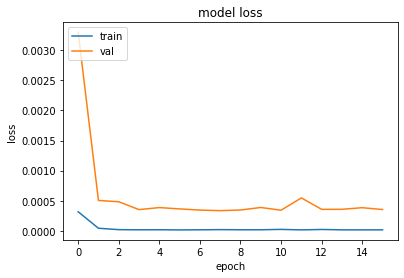

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0022 RMSE
Test Score: 0.0434 RMSE


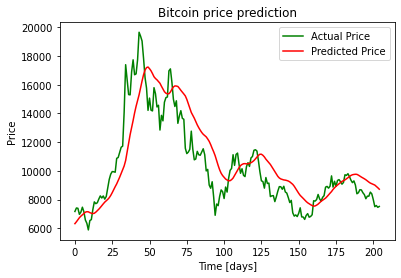

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Batch Size: 128

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(time_steps, input_shape=(time_steps, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(time_steps, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE*8,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
6/6 [==============================] - 5s 296ms/step - loss: 4.8593e-04 - val_loss: 0.0137
Epoch 2/30
6/6 [==============================] - 0s 77ms/step - loss: 1.8026e-04 - val_loss: 0.0061
Epoch 3/30
6/6 [==============================] - 0s 75ms/step - loss: 5.5321e-05 - val_loss: 3.6662e-04
Epoch 4/30
6/6 [==============================] - 0s 72ms/step - loss: 3.1434e-05 - val_loss: 0.0015
Epoch 5/30
6/6 [==============================] - 0s 71ms/step - loss: 2.2521e-05 - val_loss: 8.5220e-04
Epoch 6/30
6/6 [==============================] - 0s 76ms/step - loss: 2.5095e-05 - val_loss: 8.7103e-04
Epoch 7/30
6/6 [==============================] - 0s 77ms/step - loss: 1.6094e-05 - val_loss: 3.9221e-04
Epoch 8/30
6/6 [==============================] - 0s 73ms/step - loss: 2.5482e-05 - val_loss: 3.8857e-04
Epoch 9/30
6/6 [==============================] - 0s 73ms/step - loss: 1.7047e-05 - val_loss: 3.9910e-04
Epoch 10/30
6/6 [==============================] - 0s 73ms/step - 

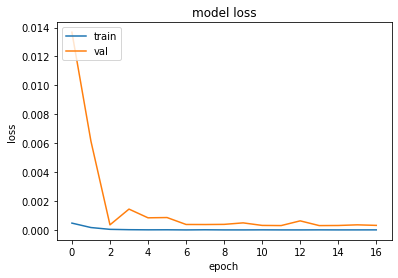

26/26 [==============================] - 0s 11ms/step
Train Score: 0.0002 RMSE
Test Score: 0.0445 RMSE


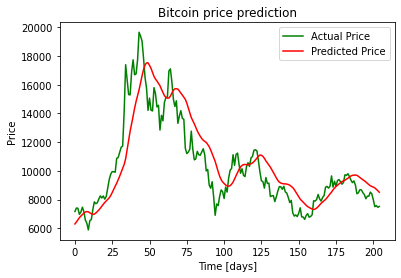

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Continuidade

Observando os resultados encontrados, o batch size de tamanho 16 já é suficiente.

### Análise 7 (Tamanho da Janela)

Nesta análise, testamos diferentes tamanhos de janela variando a quantidade de dias anteriores a serem utilizados na previsão. Para isso, utilizamos os parâmetros que consideramos melhores nas análises anteriores.

#### Tamanho da Janela: 50

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=50)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(50, input_shape=(50, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(50, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
49/49 [==============================] - 5s 23ms/step - loss: 5.0477e-05 - val_loss: 3.2727e-04
Epoch 2/30
49/49 [==============================] - 0s 8ms/step - loss: 9.5347e-06 - val_loss: 2.5429e-04
Epoch 3/30
49/49 [==============================] - 0s 9ms/step - loss: 9.0162e-06 - val_loss: 3.8843e-04
Epoch 4/30
49/49 [==============================] - 0s 9ms/step - loss: 7.5338e-06 - val_loss: 3.2334e-04
Epoch 5/30
49/49 [==============================] - 0s 8ms/step - loss: 8.8034e-06 - val_loss: 3.0813e-04
Epoch 6/30
49/49 [==============================] - 0s 8ms/step - loss: 9.2773e-06 - val_loss: 3.8691e-04
Epoch 7/30
49/49 [==============================] - 0s 8ms/step - loss: 7.8679e-06 - val_loss: 2.6102e-04
Epoch 8/30
49/49 [==============================] - 0s 9ms/step - loss: 8.0148e-06 - val_loss: 2.7734e-04
Epoch 9/30
49/49 [==============================] - 0s 9ms/step - loss: 8.0071e-06 - val_loss: 3.5902e-04
Epoch 10/30
49/49 [==========================

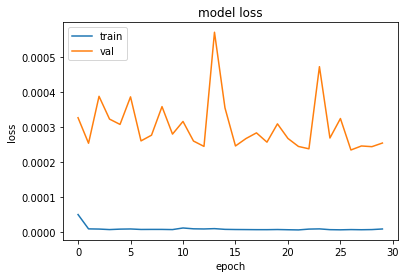

31/31 [==============================] - 0s 4ms/step
Train Score: 0.0015 RMSE
Test Score: 0.0273 RMSE


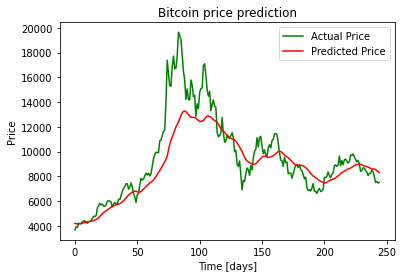

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Tamanho da Janela: 100

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=100)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(100, input_shape=(100, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(100, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
47/47 [==============================] - 6s 64ms/step - loss: 8.2393e-05 - val_loss: 7.2754e-04
Epoch 2/30
47/47 [==============================] - 1s 17ms/step - loss: 1.0372e-05 - val_loss: 3.1344e-04
Epoch 3/30
47/47 [==============================] - 1s 14ms/step - loss: 1.0352e-05 - val_loss: 2.4524e-04
Epoch 4/30
47/47 [==============================] - 1s 12ms/step - loss: 1.2006e-05 - val_loss: 4.3634e-04
Epoch 5/30
47/47 [==============================] - 1s 11ms/step - loss: 1.0670e-05 - val_loss: 9.0417e-04
Epoch 6/30
47/47 [==============================] - 1s 12ms/step - loss: 1.1335e-05 - val_loss: 2.3943e-04
Epoch 7/30
47/47 [==============================] - 1s 12ms/step - loss: 1.5235e-05 - val_loss: 2.9884e-04
Epoch 8/30
47/47 [==============================] - 1s 12ms/step - loss: 1.2795e-05 - val_loss: 2.7590e-04
Epoch 9/30
47/47 [==============================] - 1s 12ms/step - loss: 9.7294e-06 - val_loss: 3.8085e-04
Epoch 10/30
47/47 [==================

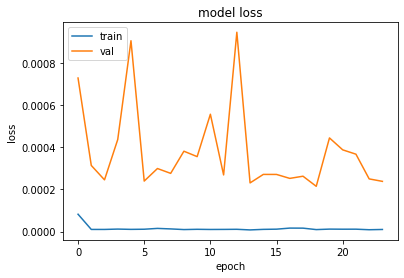

30/30 [==============================] - 0s 7ms/step
Train Score: 0.0004 RMSE
Test Score: 0.0079 RMSE


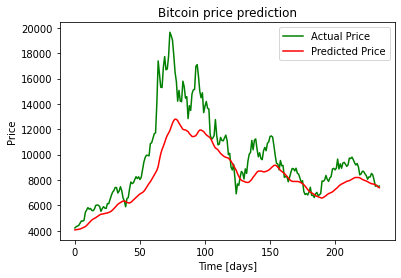

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Tamanho da Janela: 150

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=150)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(150, input_shape=(150, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(150, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
45/45 [==============================] - 5s 39ms/step - loss: 1.0069e-04 - val_loss: 0.0016
Epoch 2/30
45/45 [==============================] - 1s 19ms/step - loss: 1.3796e-05 - val_loss: 3.0612e-04
Epoch 3/30
45/45 [==============================] - 1s 18ms/step - loss: 1.0047e-05 - val_loss: 4.6295e-04
Epoch 4/30
45/45 [==============================] - 1s 14ms/step - loss: 8.8633e-06 - val_loss: 3.4103e-04
Epoch 5/30
45/45 [==============================] - 1s 14ms/step - loss: 1.0873e-05 - val_loss: 6.4266e-04
Epoch 6/30
45/45 [==============================] - 1s 14ms/step - loss: 1.2464e-05 - val_loss: 3.1723e-04
Epoch 7/30
45/45 [==============================] - 1s 14ms/step - loss: 1.2180e-05 - val_loss: 5.7638e-04
Epoch 8/30
45/45 [==============================] - 1s 14ms/step - loss: 1.2966e-05 - val_loss: 3.4335e-04
Epoch 9/30
45/45 [==============================] - 1s 14ms/step - loss: 1.7281e-05 - val_loss: 2.7999e-04
Epoch 10/30
45/45 [======================

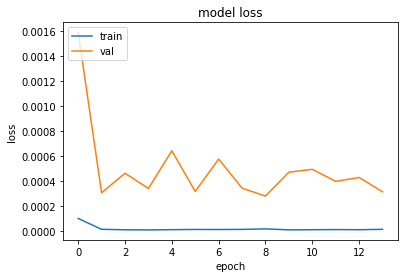

29/29 [==============================] - 0s 5ms/step
Train Score: 0.0020 RMSE
Test Score: 0.0614 RMSE


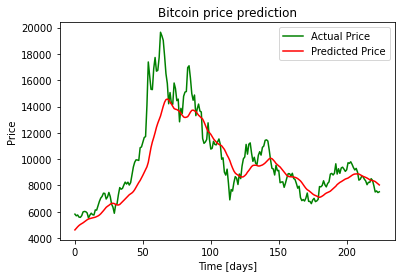

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Tamanho da Janela: 200

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=200)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(200, input_shape=(200, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(200, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
43/43 [==============================] - 6s 40ms/step - loss: 1.3739e-04 - val_loss: 3.8431e-04
Epoch 2/30
43/43 [==============================] - 1s 20ms/step - loss: 1.7494e-05 - val_loss: 6.7280e-04
Epoch 3/30
43/43 [==============================] - 1s 20ms/step - loss: 1.8059e-05 - val_loss: 3.4374e-04
Epoch 4/30
43/43 [==============================] - 1s 20ms/step - loss: 1.8970e-05 - val_loss: 4.6605e-04
Epoch 5/30
43/43 [==============================] - 1s 22ms/step - loss: 1.3375e-05 - val_loss: 3.7136e-04
Epoch 6/30
43/43 [==============================] - 1s 20ms/step - loss: 1.5009e-05 - val_loss: 9.5330e-04
Epoch 7/30
43/43 [==============================] - 1s 20ms/step - loss: 1.4602e-05 - val_loss: 8.1061e-04
Epoch 8/30
43/43 [==============================] - 1s 20ms/step - loss: 1.6177e-05 - val_loss: 4.0604e-04
Epoch 9/30
43/43 [==============================] - 1s 20ms/step - loss: 1.9431e-05 - val_loss: 3.5886e-04
Epoch 10/30
43/43 [==================

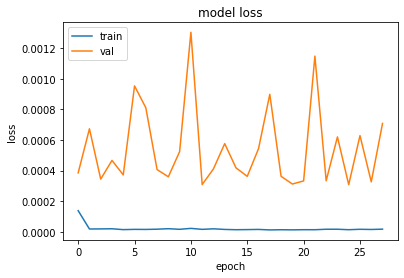

27/27 [==============================] - 0s 12ms/step
Train Score: 0.0016 RMSE
Test Score: 0.0196 RMSE


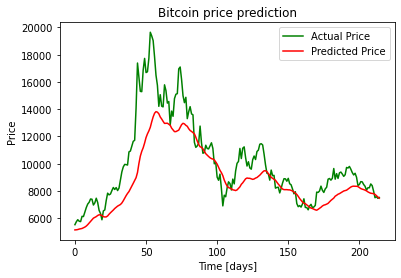

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Tamanho da Janela: 250

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=250)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(250, input_shape=(250, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(250, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
41/41 [==============================] - 6s 47ms/step - loss: 1.3913e-04 - val_loss: 3.0756e-04
Epoch 2/30
41/41 [==============================] - 1s 26ms/step - loss: 1.8720e-05 - val_loss: 4.1934e-04
Epoch 3/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0926e-05 - val_loss: 0.0016
Epoch 4/30
41/41 [==============================] - 1s 26ms/step - loss: 2.0155e-05 - val_loss: 4.1954e-04
Epoch 5/30
41/41 [==============================] - 1s 26ms/step - loss: 1.9287e-05 - val_loss: 4.2983e-04
Epoch 6/30
41/41 [==============================] - 1s 27ms/step - loss: 1.7320e-05 - val_loss: 4.6493e-04
Epoch 7/30
41/41 [==============================] - 1s 26ms/step - loss: 2.2789e-05 - val_loss: 3.8226e-04
Epoch 8/30
41/41 [==============================] - 1s 26ms/step - loss: 2.1222e-05 - val_loss: 2.9591e-04
Epoch 9/30
41/41 [==============================] - 1s 27ms/step - loss: 2.4568e-05 - val_loss: 6.7387e-04
Epoch 10/30
41/41 [======================

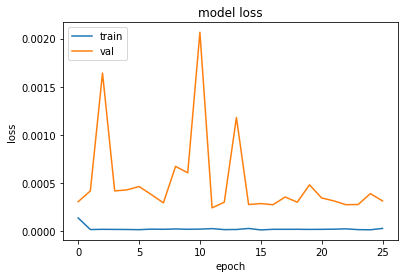

26/26 [==============================] - 0s 13ms/step
Train Score: 0.0026 RMSE
Test Score: 0.0323 RMSE


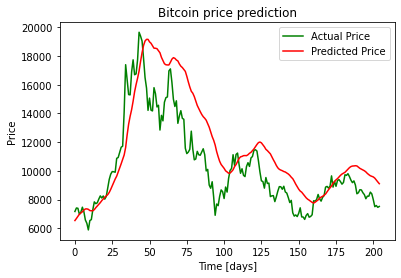

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Tamanho da Janela: 300

In [ ]:
X_train, y_train, X_test, y_test = split_data(scaled_df, 0.2, time_steps=300)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
model_LSTM_2_adam = tf.keras.Sequential()
model_LSTM_2_adam.add(LSTM(300, input_shape=(300, X_train.shape[-1]), dropout=DROPOUT, return_sequences=True))
model_LSTM_2_adam.add(LSTM(300, dropout=DROPOUT))
model_LSTM_2_adam.add(Dense(1, activation='linear'))
model_LSTM_2_adam.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    loss="mse"
)

In [ ]:
history_LSTM_2_adam = model_LSTM_2_adam.fit(
    np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1),
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=VERBOSE,
    validation_split=0.2,
    callbacks=[callback]
)

Epoch 1/30
39/39 [==============================] - 8s 60ms/step - loss: 1.5022e-04 - val_loss: 0.0013
Epoch 2/30
39/39 [==============================] - 1s 37ms/step - loss: 5.7369e-05 - val_loss: 5.8094e-04
Epoch 3/30
39/39 [==============================] - 1s 37ms/step - loss: 2.7317e-05 - val_loss: 4.1755e-04
Epoch 4/30
39/39 [==============================] - 1s 37ms/step - loss: 3.3659e-05 - val_loss: 0.0012
Epoch 5/30
39/39 [==============================] - 1s 37ms/step - loss: 3.7953e-05 - val_loss: 4.4349e-04
Epoch 6/30
39/39 [==============================] - 1s 37ms/step - loss: 2.3390e-05 - val_loss: 0.0015
Epoch 7/30
39/39 [==============================] - 1s 38ms/step - loss: 3.5204e-05 - val_loss: 8.9232e-04
Epoch 8/30
39/39 [==============================] - 1s 38ms/step - loss: 1.8590e-05 - val_loss: 3.9149e-04
Epoch 9/30
39/39 [==============================] - 1s 38ms/step - loss: 3.5390e-05 - val_loss: 0.0021
Epoch 10/30
39/39 [==============================] - 

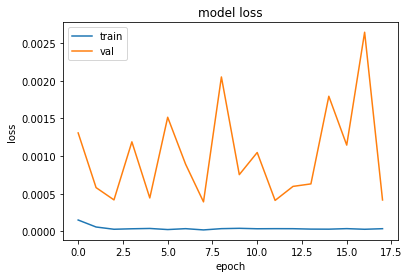

25/25 [==============================] - 0s 18ms/step
Train Score: 0.0053 RMSE
Test Score: 0.0305 RMSE


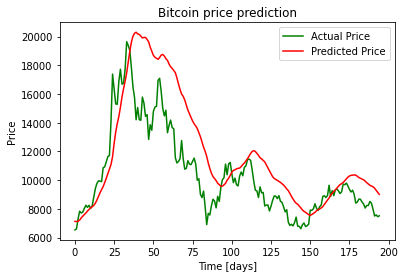

In [ ]:
model_evaluation(history_LSTM_2_adam, model_LSTM_2_adam, scaler, X_test, X_train, y_train, y_test)

#### Continuidade

Olhando para os scores com RMSE, vemos que o melhor modelo é com tamanho de janela igual a 100.


### Conclusão

Dessa forma, a partir dessa abordagem, os melhores parâmetros encontrados para a previsão de valores dee Bitcoin, com RMSE 0,0004 de treinamento e 0,0079 de teste, foram:
- 2 camadas LSTM
- Algoritmo de Otimização: ADAM
- Taxa de aprendizagem: 0.001
- Dropout: 10%
- Batch Size: 16
- Tamanho da janela: 100